# Noise Analysis

This script's purpose is to evaluate the noise across the brain and see how resilient the SNR changes with region and noise.

In [10]:
#%matplotlib widget
import scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import sys
import os
import functools
from matplotlib import colors

In [11]:
cwd_temp = os.getcwd()
base_file = 'Regularization'
cwd_full = cwd_temp.split(base_file, 1)[0]

brain_data = scipy.io.loadmat(f'{cwd_full}{base_file}/MB_References/BLSA_1742_04_MCIAD_m41/NESMA_cropped_slice5.mat')
I_raw = brain_data['slice_oi']

subsection = False

if subsection:
    I_raw_vert = 5
    I_raw_hori = 36
    I_raw_extent = 60
    I_raw = I_raw[I_raw_vert:I_raw_vert + I_raw_extent, I_raw_hori:I_raw_hori + I_raw_extent, :]

n_vert, n_hori, n_elements = I_raw.shape

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata = np.linspace(t_increment_brain, (n_elements)*(t_increment_brain), n_elements)

#All pixels with a lower mask amplitude are considered to be free water (i.e. vesicles)
mask_amplitude = 750

#This is important for regularization if this is deemed necessary here
ob_weight = 100

MB_model = False

init_p = (0.3, 0.7, 20, 80)
lb = [0,0,0,0]
ub = [np.inf,np.inf, 80, 300]
bound_list = (lb, ub)

ParamLabel = [r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

# vert1 = 165
# vert2 = 180
# hori1 = 120
# hori2 = 180

# vert1 = 33
# vert2 = 43
# hori1 = 25
# hori2 = 59

vert1 = 92             #60     #108
vert2 = 110            #125     #116
hori1 = 75            #100      #86
hori2 = 130 

vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

noiseRegion = [vert1,vert2,hori1,hori2]

In [12]:
def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def get_brain_outline(raw):
    I_outline = np.zeros((n_vert,n_hori))
    for i_vert in range(n_vert):
        for i_hori in range(n_hori):
            try:
                init_sig = raw[i_vert, i_hori, 0]
                init_sig_up = raw[i_vert-1, i_hori, 0]
                init_sig_lt = raw[i_vert, i_hori-1, 0]
                init_sig_rt = raw[i_vert, i_hori+1, 0]
                init_sig_dn = raw[i_vert+1, i_hori, 0]
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = 0
    return I_outline

/home/hamptong2/anaconda3/envs/BrainReg/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/hamptong2/anaconda3/envs/BrainReg/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


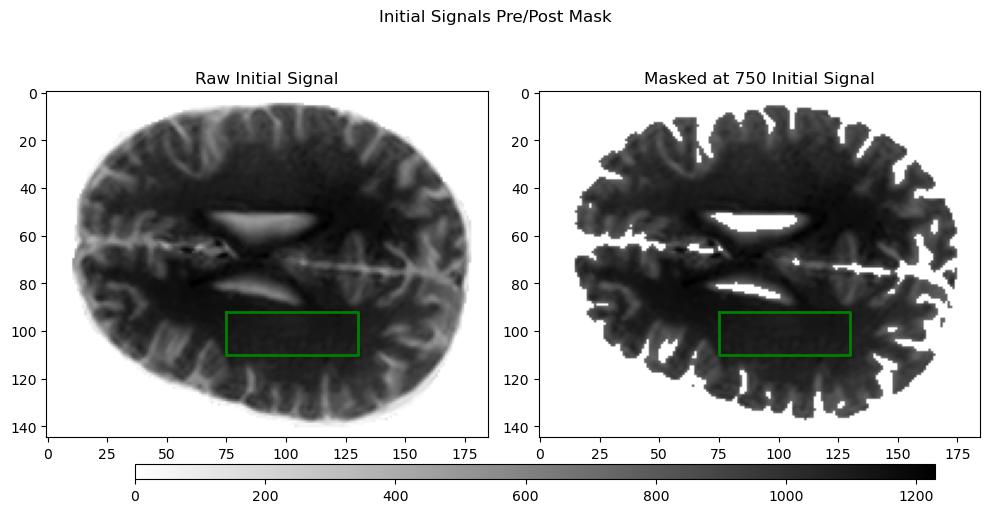

In [13]:
I_data = mask_data(I_raw, mask_amplitude)

fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(10,5))
fig.suptitle('Initial Signals Pre/Post Mask')
imc1 = ax[0].imshow(I_raw[:, :, 0], cmap = 'binary')
ax[0].set_title(f"Raw Initial Signal")
ax[0].plot(hBox,vBox, linewidth = 2, color = 'g')
imc1 = ax[1].imshow(I_data[:, :, 0], cmap = 'binary')
ax[1].set_title(f"Masked at {mask_amplitude} Initial Signal")
ax[1].plot(hBox,vBox, linewidth = 2, color = 'g')
cbar_ax = fig.add_axes([0.14, 0.04, 0.8, 0.03])

fig.colorbar(imc1, ax=ax, cax=cbar_ax, orientation = 'horizontal', fraction=0.046, pad=0.04)

In [14]:
v1,v2,h1,h2 = noiseRegion
print(f"The periventricular brain subsection average final signal is {np.mean(I_data[v1:v2,h1:h2,-1]):.2f}")
print(f"The periventricular brain subsection average final three signals is {np.mean(I_data[v1:v2,h1:h2,-3:]):.2f}")

noise_floor = np.mean(I_data[v1:v2,h1:h2,-3:])#np.mean([i for i in I_nonzero_avg_last_val if i >= lower if i<= upper])
sigma = noise_floor * (2/np.pi)**(1/2)
print("Determined from the Boxed Region")
print(f'sigma = {sigma}')
avg_init = np.mean(I_data[v1:v2,h1:h2,0])
rician_SNR = avg_init/sigma
print(f'SNR = {rician_SNR:0.2f}')

The periventricular brain subsection average final signal is 23.52
The periventricular brain subsection average final three signals is 25.59
Determined from the Boxed Region
sigma = 20.4186049673904
SNR = 53.91


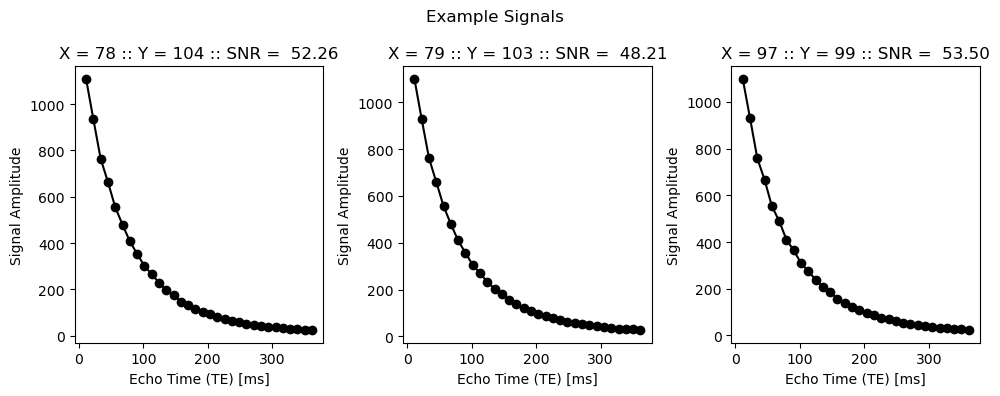

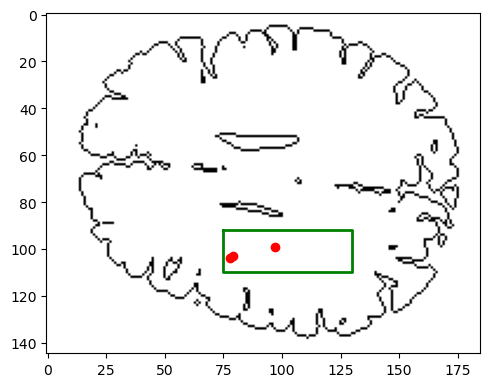

In [15]:
rand_x = [random.randint(h1, h2) for _ in range(3)]
rand_y = [random.randint(v1, v2) for _ in range(3)]

fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(10,4))
fig.suptitle('Example Signals')
for i in range(3):
    ax[i].plot(tdata, I_data[rand_y[i], rand_x[i], :], ls = '-', marker = 'o', color = 'k')
    ax[i].set_title(f"X = {rand_x[i]} :: Y = {rand_y[i]} :: SNR = {I_data[rand_y[i], rand_x[i], 0]/(np.mean(I_data[rand_y[i], rand_x[i], -3:]) * (2/np.pi)**(1/2)): .2f}")
    ax[i].set_ylabel('Signal Amplitude')
    ax[i].set_xlabel('Echo Time (TE) [ms]')

brain_outline = get_brain_outline(I_data)
fig, ax = plt.subplots(1,1,figsize=(5,5),tight_layout=True)
ax.imshow(1-brain_outline, cmap = 'gray')
ax.plot(hBox,vBox, linewidth = 2, color = 'g')
ax.plot(rand_x, rand_y, ls = '', color = 'r', marker = 'o')

In [16]:
############# Signal Functions ##############

def G_biX(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def expRice(tvect,c1,c2,T21,T22):
    alpha=(G_biX(tvect, c1, c2, T21, T22)/(2*sigma))**2
    Expectation = sigma*np.sqrt(np.pi/2)*((1+2*alpha)*scipy.special.ive(0, alpha) + 2*alpha*scipy.special.ive(1,alpha))
    return Expectation

#This is used with regularization
def G_regRice(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def G_lam(t, con1, con2, tau1, tau2):
        return np.append(expRice(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return G_lam

In [17]:
def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def estimate_parameters(tvect, noised_data, init_p, bnds, lamb = 0):
    parameter_tail = np.zeros(len(init_p))
    regData = np.append(noised_data, parameter_tail)
    popt, _, info, _, _ = curve_fit(G_regRice(lamb), tdata, regData, p0=init_p, bounds = bnds, full_output = True, maxfev = 4000)
    popt = check_param_order(popt)
    regRSS = np.sum(info['fvec']**2)
    RSS = np.sum(info['fvec'][:-4]**2)
    return popt, regRSS, RSS

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,4))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    coeficients = np.where(coeficients == 0, 1-coeficients, coeficients) #to avoid dividing by zero
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

In [18]:
NLLS_estimates = np.zeros((n_vert, n_hori, 4))
NLLS_regRSS = np.zeros((n_vert, n_hori))
NLLS_RSS = np.zeros((n_vert, n_hori))

#This should take about 6 minutes for a 288 by 288 pixel image for 32 echos
for i_vert in trange(n_vert):
    for i_hori in range(n_hori):

        noise_data = I_data[i_vert, i_hori, :]
    
        if np.all(noise_data == 0):
            NLLS_estimates[i_vert, i_hori, :] = [0,0,0,0]
            NLLS_RSS[i_vert, i_hori] = np.nan
        else:
            #Have to adjust the initial parameter values since there is no pre-normalization
            temp_p0 = np.copy(init_p)
            temp_p0[0] = temp_p0[0]*noise_data[0]
            temp_p0[1] = temp_p0[1]*noise_data[0]
            est_params, est_regRSS, est_RSS = estimate_parameters(tdata, noise_data, temp_p0, bound_list)
        
            NLLS_estimates[i_vert, i_hori, :] = est_params
            NLLS_RSS[i_vert, i_hori] = est_RSS
            NLLS_regRSS[i_vert, i_hori] = est_regRSS

100%|██████████| 145/145 [03:42<00:00,  1.53s/it]


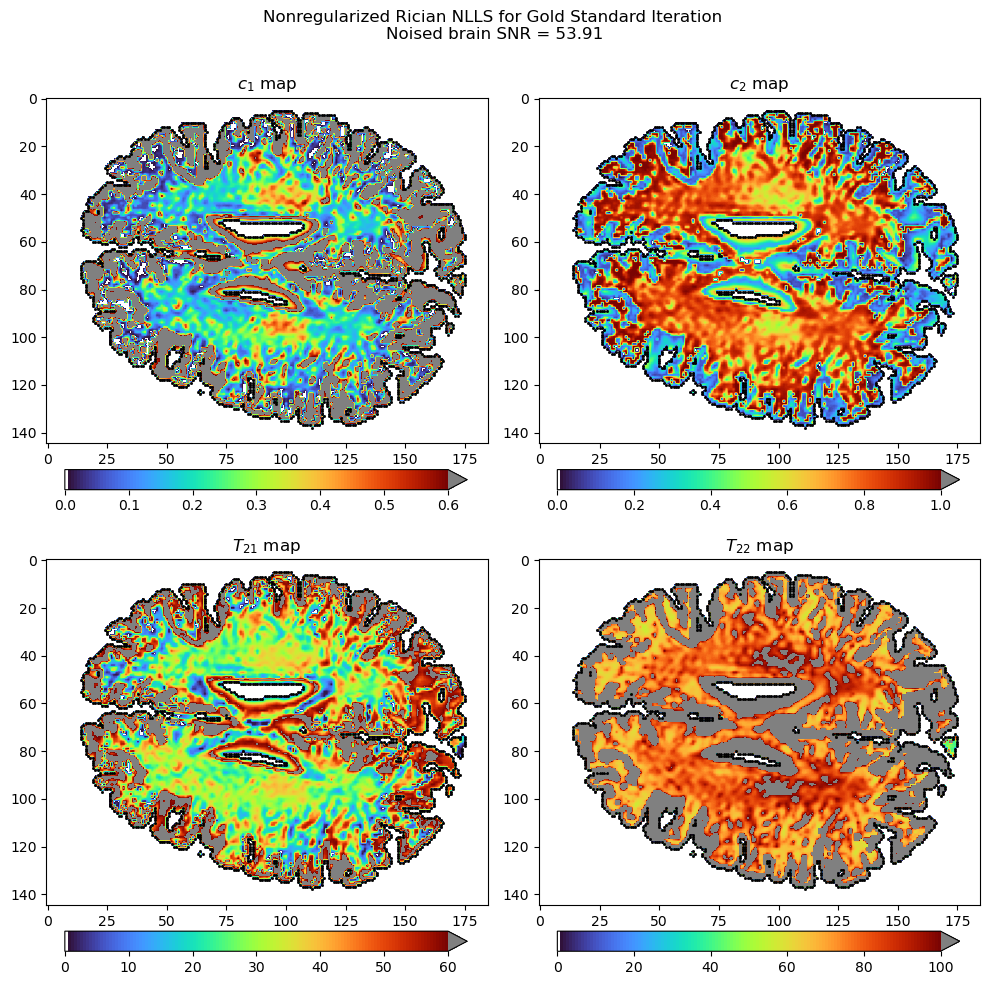

In [21]:
non_norm_params = NLLS_estimates
norm_params = post_normalize(NLLS_estimates)

fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle(f'Nonregularized Rician NLLS for Gold Standard Iteration \nNoised brain SNR = {rician_SNR:.2f}' )

vmax_list = [0.6,1,60,100]
MWF_cb_map = plt.get_cmap('turbo', 128)
stack_white = np.vstack(((1,0,0,0),MWF_cb_map(np.linspace(0,1,128))))
MWF_cb_map = colors.ListedColormap(stack_white, name = 'MWF_cb_map')
MWF_cb_map.set_extremes(over = 'grey')

outline_indices = np.where(brain_outline == 1)

for i in range(4):
    imc1 = ax[i//2,i%2].imshow(norm_params[:,:,i], cmap = MWF_cb_map, vmin=0, vmax = vmax_list[i])
    ax[i//2,i%2].set_title(f'{ParamLabel[i]} map')
    
    ax[i//2,i%2].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)
    fig.colorbar(imc1, ax=ax[i//2,i%2], location = 'bottom', orientation = 'horizontal', fraction=0.046, pad=0.06, extend = 'max')

plt.show()